In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.sr_dataset import DatasetSR
from PIL import Image as im

from models.EDSR import EDSR
import torch
import torch.nn as nn
from utils.utils import calculate_psnr,calculate_ssim
from tqdm import tqdm
from dataset.sr_dataset import DatasetSR
from einops import rearrange
from torch.utils.data import DataLoader
import cv2
import glob
import os

In [3]:
train_dataset=DatasetSR(phase='train',scale=4)
val_dataset=DatasetSR(phase='val',scale=4)

In [26]:
data=train_dataset[350]
L=np.array(data['L']).transpose(1,2,0)
H=np.array(data['H']).transpose(1,2,0)
oL=np.array(data['OL']).transpose(1,2,0)
oH=np.array(data['OH']).transpose(1,2,0)

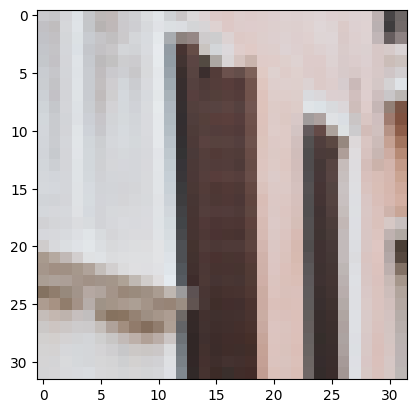

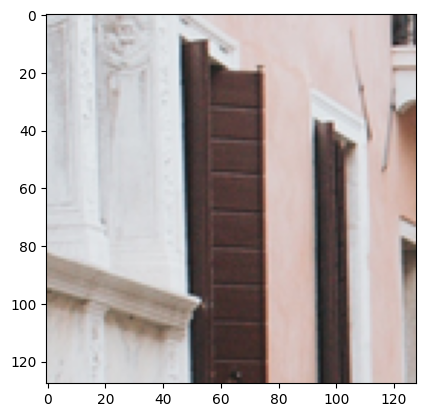

In [27]:
plt.imshow(L)
plt.show()
plt.imshow(H)
plt.show()